### Stage 4: IntensityGroup binary classification

In [534]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

### 1. Data Preprocessing

#### 1.1. Data Loading

In [535]:
FitBit_data = pd.read_csv("FitBit_clustered_data.csv")
FitBit_data

,Id,Day,Calories,Steps,TotalMinutesAsleep,IntensityGroup,FitnessGroup
0,1503960366,2016-04-12,1985,13162,327.0,1,3
1,1503960366,2016-04-13,1797,10735,384.0,1,3
2,1503960366,2016-04-15,1745,9762,412.0,0,3
3,1503960366,2016-04-16,1863,12669,340.0,1,3
4,1503960366,2016-04-17,1728,9705,700.0,1,2
...,...,...,...,...,...,...,...
408,8792009665,2016-04-30,2896,7174,343.0,0,1
409,8792009665,2016-05-01,1962,1619,503.0,0,2
410,8792009665,2016-05-02,2015,1831,415.0,0,2
411,8792009665,2016-05-03,2297,2421,516.0,0,2


In [536]:
FitBit_data.describe()

,Id,Calories,Steps,TotalMinutesAsleep,IntensityGroup,FitnessGroup
count,4.130000e+02,413.000000,413.000000,413.000000,413.000000,413.000000
mean,5.000979e+09,2397.573850,8541.140436,419.467312,0.375303,1.857143
std,2.060360e+09,762.886326,4156.926990,118.344679,0.484788,0.922443
min,1.503960e+09,257.000000,17.000000,58.000000,0.000000,0.000000
25%,3.977334e+09,1850.000000,5206.000000,361.000000,0.000000,1.000000
50%,4.702922e+09,2220.000000,8925.000000,433.000000,0.000000,2.000000
75%,6.962181e+09,2926.000000,11393.000000,490.000000,1.000000,3.000000
max,8.792010e+09,4900.000000,22770.000000,796.000000,1.000000,3.000000


#### 1.2. Select Target and Features

In [537]:
x_unscaled = FitBit_data[["Calories", "Steps", "TotalMinutesAsleep"]] # Select features
y = np.array(FitBit_data[["IntensityGroup"]]).ravel() # Select target

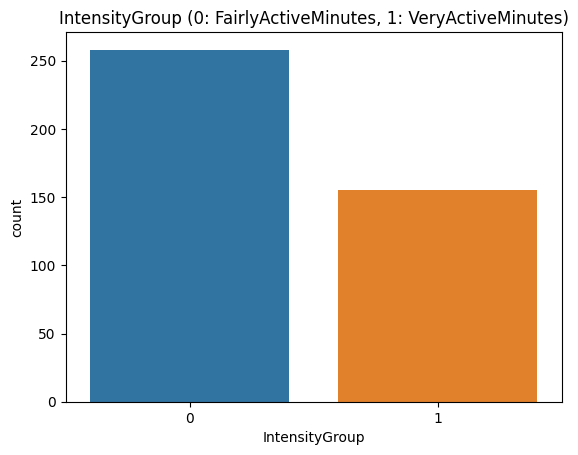

In [538]:
sns.countplot(x=FitBit_data["IntensityGroup"])
plt.title("IntensityGroup (0: FairlyActiveMinutes, 1: VeryActiveMinutes)")
plt.show()

#### 1.3. Data Scaling

Feature scaling in Machine Learning is a method used to normalize the range of independent variables or features of data. Gradient descent and distance-based algorithms are heavily impacted by the range of features.

In [539]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on your data
x = pd.DataFrame(scaler.fit_transform(x_unscaled), columns=x_unscaled.columns)

In [540]:
# Save the scaler in order to use it in external application
joblib.dump(scaler, "scaler_classification.joblib")

# How to use it later: load the scaler from the file
loaded_scaler = joblib.load("scaler_classification.joblib")

input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the loaded scaler to transform new data
output_data = pd.DataFrame(loaded_scaler.transform(input_data), columns=input_data.columns)
output_data

,Calories,Steps,TotalMinutesAsleep
0,-0.788194,0.5284,-0.300059


#### 1.4. Train Test Split

In [541]:
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### 2. Classification Metric

Receiver Operating Characteristic (ROC) is chosen as a metric in order to synchronize approaches of multiclass and binary classifications.

### 3. Classification Step

#### 3.1. KNN Classifier

##### 3.1.1. Adjusting k parameter

Best k parameter: 19


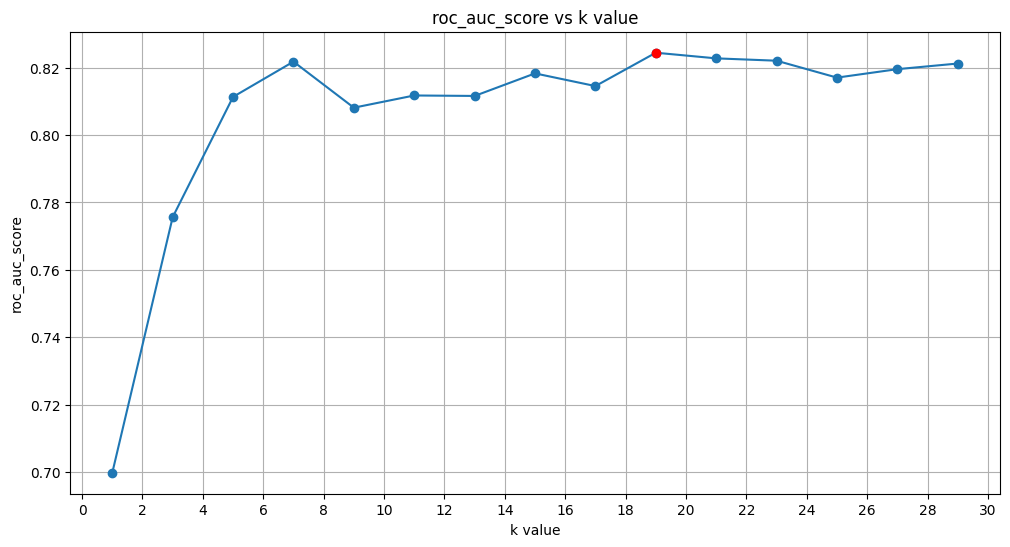

In [542]:
knn_roc_auc_score = []

for k in range(1,30,2):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(x_train,y_train)

    # Get predicted probabilities for the positive class
    y_scores = knn_classifier.predict_proba(x_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    # Compute AUC
    roc_auc = roc_auc_score(y_test, y_scores)
    knn_roc_auc_score.append(roc_auc)

best_k_parameter = np.argmax(knn_roc_auc_score)*2 + 1
print("Best k parameter:", best_k_parameter)

plt.figure(figsize=(12,6))
plt.plot(range(1,30,2), knn_roc_auc_score, marker="o")
plt.plot(best_k_parameter, knn_roc_auc_score[np.argmax(knn_roc_auc_score)], "o", c="red")
plt.locator_params(axis="x", nbins=30) 
plt.title("roc_auc_score vs k value")
plt.xlabel("k value")
plt.ylabel("roc_auc_score")
plt.grid()

##### 3.1.2. Conducting the KNN Classification

In [543]:
knn_classifier = KNeighborsClassifier(n_neighbors=best_k_parameter).fit(x_train,y_train)

##### 3.1.3. KNN ROC-curve

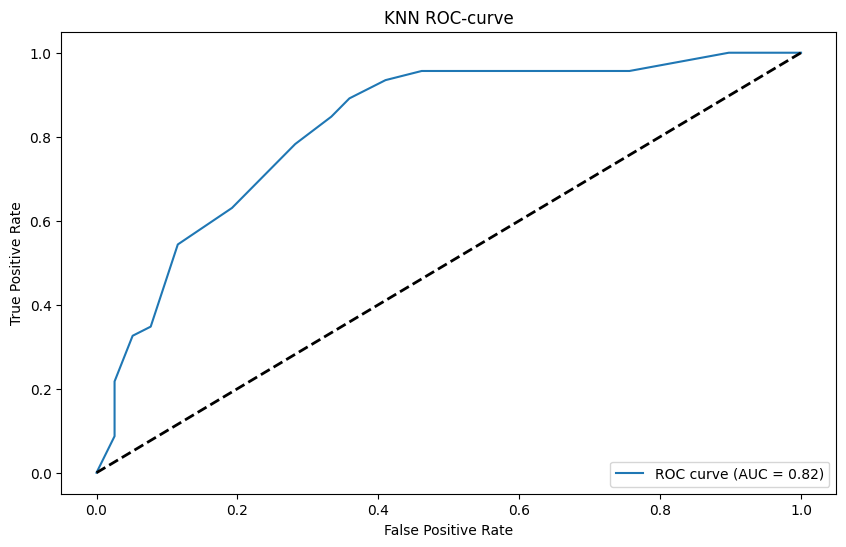

In [544]:
y_scores = knn_classifier.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
knn_roc_auc_score = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {knn_roc_auc_score:.2f})')

plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC-curve")
plt.legend(loc="lower right")
plt.show()

##### 3.1.4. Confusion Matrix

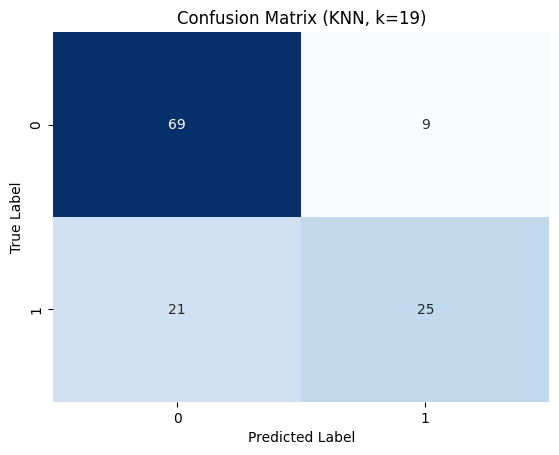

In [545]:
knn_confusion_matrix = confusion_matrix(y_test, knn_classifier.predict(x_test))

# Plot the confusion matrix using seaborn
sns.heatmap(knn_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y),yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (KNN, k={best_k_parameter})")
plt.show()

##### 3.1.5. KNN Prediction

In [546]:
pure_input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the scaler to transform new data
input_data = pd.DataFrame(scaler.transform(pure_input_data), columns=pure_input_data.columns)

output_data = knn_classifier.predict(input_data)[0]

knn_classifier_prediction = pure_input_data
knn_classifier_prediction["IntensityGroup"] = output_data
knn_classifier_prediction

,Calories,Steps,TotalMinutesAsleep,IntensityGroup
0,1797,10735,384.0,1


#### 3.2. Decision Tree Classifier

##### 3.2.1. Adjusting max_depth parameter

Best max_depth parameter: 3


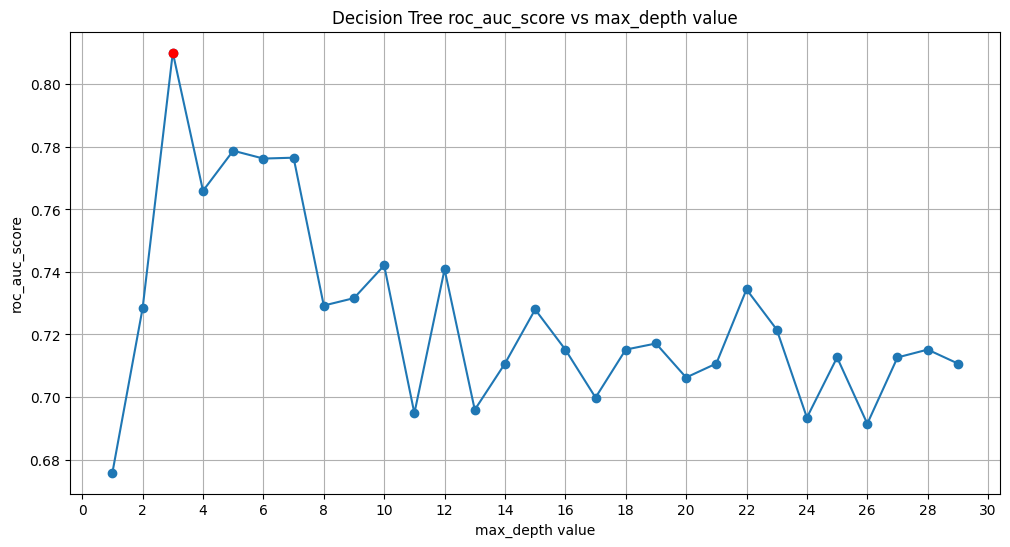

In [547]:
decision_tree_roc_auc_score = []

for max_depth_value in range(1,30):
    decision_tree_classifier = DecisionTreeClassifier(max_depth=max_depth_value)
    decision_tree_classifier.fit(x_train,y_train)

    # Get predicted probabilities for the positive class
    y_scores = decision_tree_classifier.predict_proba(x_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    # Compute AUC
    roc_auc = roc_auc_score(y_test, y_scores)
    decision_tree_roc_auc_score.append(roc_auc)

decision_tree_best_max_depth_parameter = np.argmax(decision_tree_roc_auc_score) + 1
print("Best max_depth parameter:", decision_tree_best_max_depth_parameter)

plt.figure(figsize=(12,6))
plt.plot(range(1,30), decision_tree_roc_auc_score, marker="o")
plt.plot(decision_tree_best_max_depth_parameter, decision_tree_roc_auc_score[decision_tree_best_max_depth_parameter-1], "o", c="red")
plt.locator_params(axis="x", nbins=30) 
plt.title("Decision Tree roc_auc_score vs max_depth value")
plt.xlabel("max_depth value")
plt.ylabel("roc_auc_score")
plt.grid()

##### 3.2.2. Conducting the Decision Tree Classification

In [548]:
decision_tree_classifier = DecisionTreeClassifier(
    max_depth=decision_tree_best_max_depth_parameter
).fit(x_train,y_train)

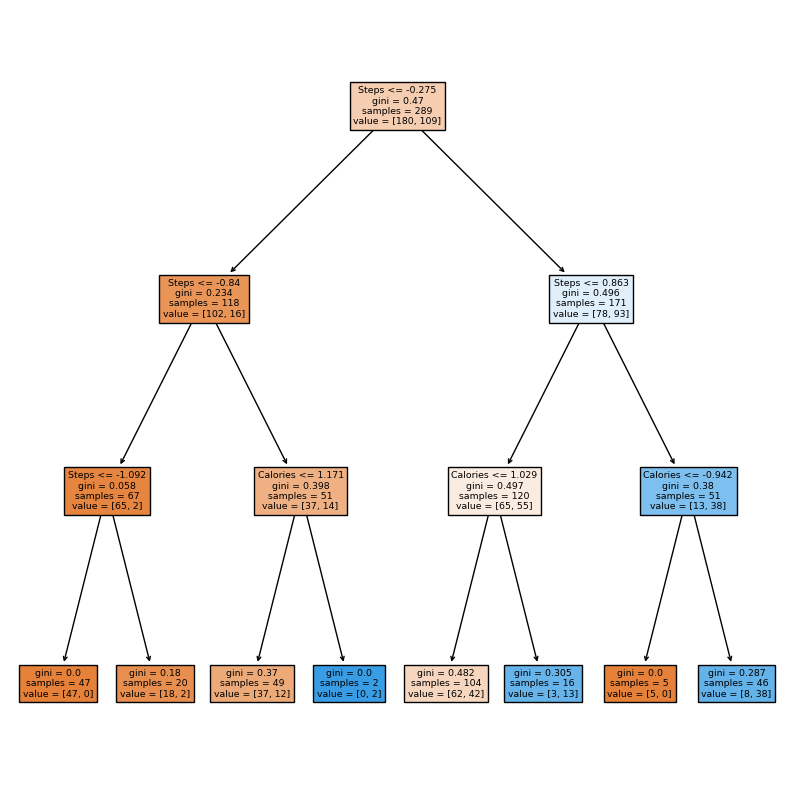

In [549]:
plt.figure(figsize = (10,10))
plot_tree(
    decision_tree_classifier, 
    feature_names=x_train.columns, 
    filled=True
)
plt.show()

##### 3.2.3. Decision Tree ROC-curve

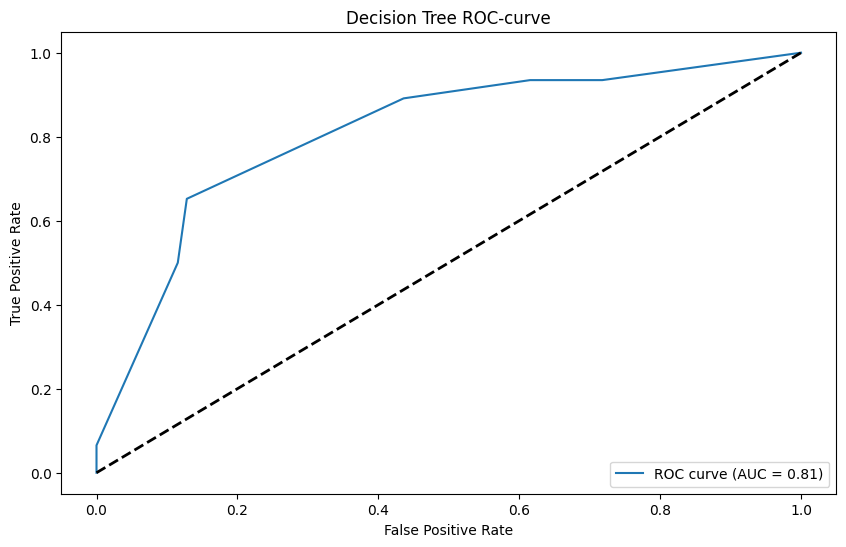

In [550]:
y_scores = decision_tree_classifier.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
decision_tree_roc_auc_score = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {decision_tree_roc_auc_score:.2f})')

plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree ROC-curve")
plt.legend(loc="lower right")
plt.show()

##### 3.2.4. Confusion Matrix

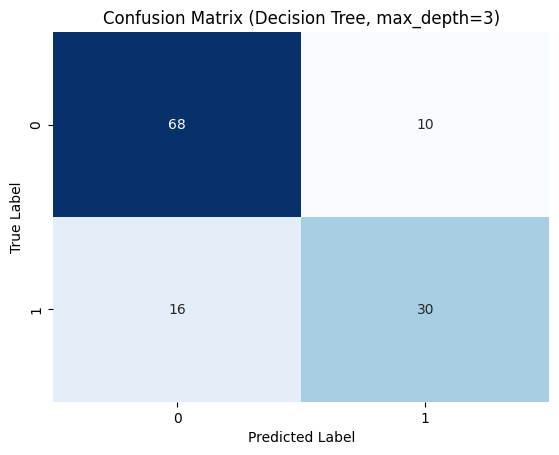

In [551]:
decision_tree_confusion_matrix = confusion_matrix(y_test, decision_tree_classifier.predict(x_test))

# Plot the confusion matrix using seaborn
sns.heatmap(decision_tree_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y),yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Decision Tree, max_depth={decision_tree_best_max_depth_parameter})")
plt.show()

##### 3.2.5. Decision Tree Prediction

In [552]:
pure_input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the scaler to transform new data
input_data = pd.DataFrame(scaler.transform(pure_input_data), columns=pure_input_data.columns)

output_data = decision_tree_classifier.predict(input_data)[0]

decision_tree_classifier_prediction = pure_input_data
decision_tree_classifier_prediction["IntensityGroup"] = output_data
decision_tree_classifier_prediction

,Calories,Steps,TotalMinutesAsleep,IntensityGroup
0,1797,10735,384.0,0


#### 3.3. Naive Bayes Classifier

##### 3.3.1. Adjusting step (postponed)

##### 3.3.2. Conducting the Naive Bayes Classification 

In [553]:
naive_bayes_classifier = GaussianNB().fit(x_train,y_train)

##### 3.3.3. Naive Bayes ROC-curve

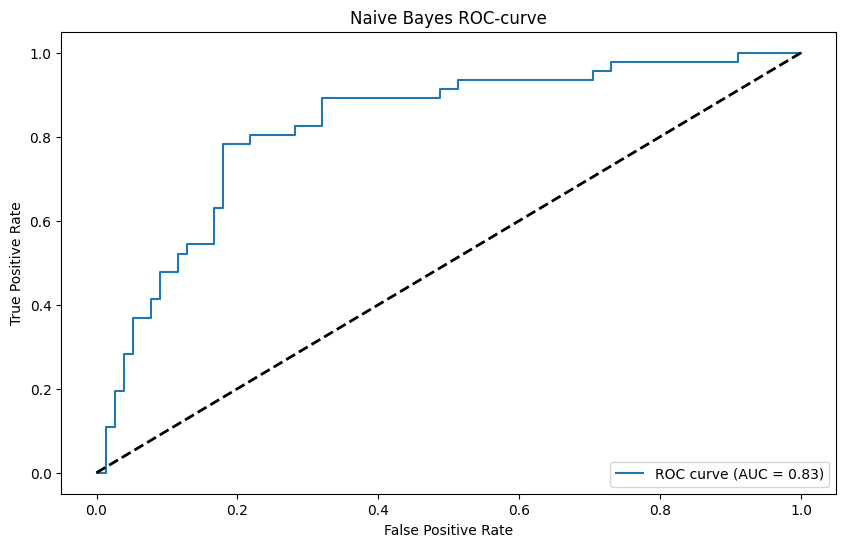

In [554]:
y_scores = naive_bayes_classifier.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
naive_bayes_roc_auc_score = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {naive_bayes_roc_auc_score:.2f})')

plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes ROC-curve")
plt.legend(loc="lower right")
plt.show()

##### 3.3.4. Confusion Matrix

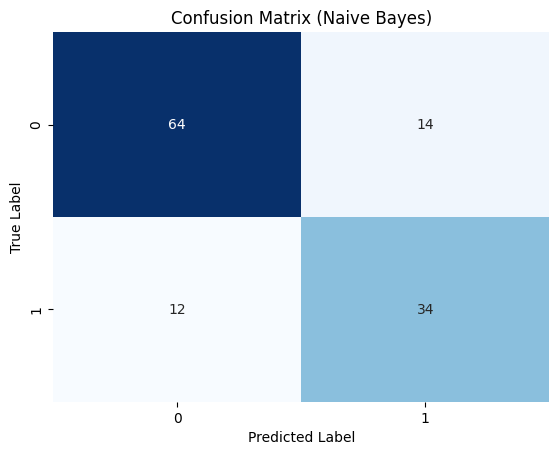

In [555]:
naive_bayes_confusion_matrix = confusion_matrix(y_test, naive_bayes_classifier.predict(x_test))

# Plot the confusion matrix using seaborn
sns.heatmap(naive_bayes_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y),yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Naive Bayes)")
plt.show()

##### 3.3.5. Naive Bayes Prediction

In [556]:
pure_input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the scaler to transform new data
input_data = pd.DataFrame(scaler.transform(pure_input_data), columns=pure_input_data.columns)

output_data = naive_bayes_classifier.predict(input_data)[0]

naive_bayes_classifier_prediction = pure_input_data
naive_bayes_classifier_prediction["IntensityGroup"] = output_data
naive_bayes_classifier_prediction

,Calories,Steps,TotalMinutesAsleep,IntensityGroup
0,1797,10735,384.0,0


#### 3.4. XGBoost Classifier

##### 3.4.1. Adjusting max_depth parameter

Best max_depth parameter: 2


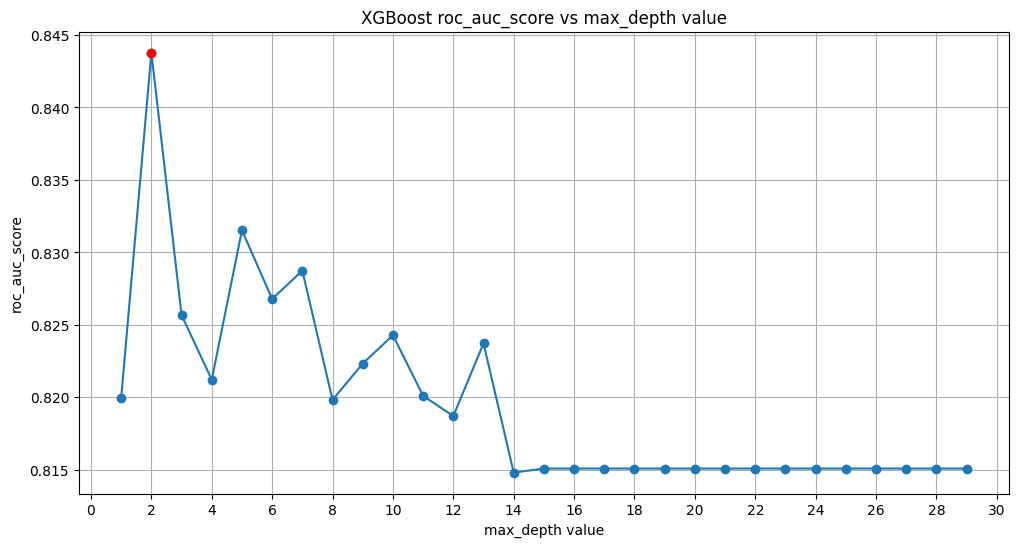

In [557]:
xgboost_roc_auc_score = []

for max_depth_value in range(1,30):
    xgboost_classifier = XGBClassifier(max_depth=max_depth_value)
    xgboost_classifier.fit(x_train,y_train)

    # Get predicted probabilities for the positive class
    y_scores = xgboost_classifier.predict_proba(x_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    # Compute AUC
    roc_auc = roc_auc_score(y_test, y_scores)
    xgboost_roc_auc_score.append(roc_auc)

xgboost_best_max_depth_parameter = np.argmax(xgboost_roc_auc_score) + 1
print("Best max_depth parameter:", xgboost_best_max_depth_parameter)

plt.figure(figsize=(12,6))
plt.plot(range(1,30), xgboost_roc_auc_score, marker="o")
plt.plot(xgboost_best_max_depth_parameter, xgboost_roc_auc_score[xgboost_best_max_depth_parameter-1], "o", c="red")
plt.locator_params(axis="x", nbins=30) 
plt.title("XGBoost roc_auc_score vs max_depth value")
plt.xlabel("max_depth value")
plt.ylabel("roc_auc_score")
plt.grid()

##### 3.4.2. Conducting the XGBoost Classification 

In [558]:
xgboost_classifier = XGBClassifier(
    max_depth=xgboost_best_max_depth_parameter
).fit(x_train,y_train)

##### 3.4.3. XGBoost ROC-curve

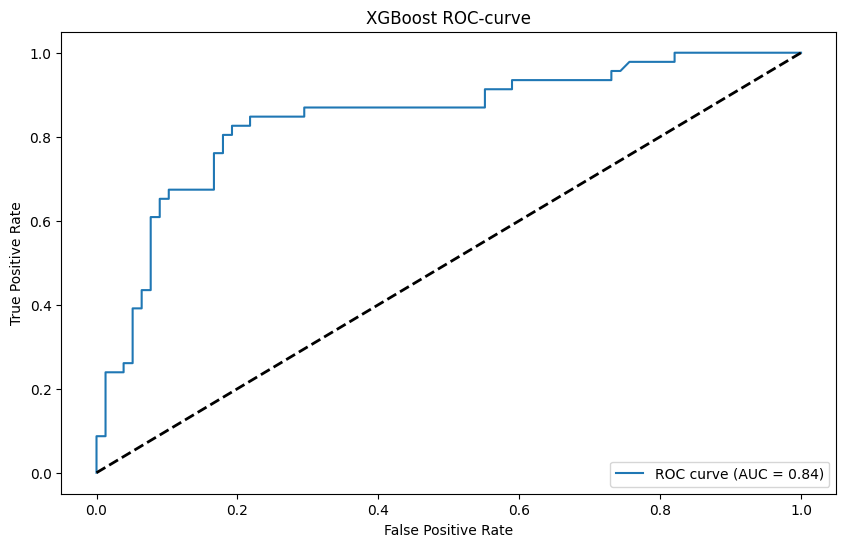

In [559]:
y_scores = xgboost_classifier.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
xgboost_roc_auc_score = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {xgboost_roc_auc_score:.2f})')

plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC-curve")
plt.legend(loc="lower right")
plt.show()

##### 3.4.4. Confusion Matrix

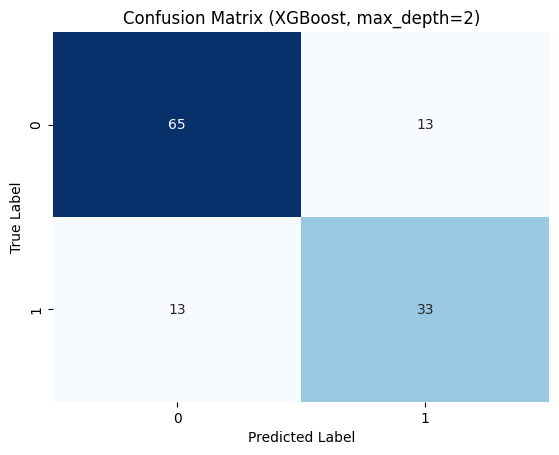

In [560]:
xgboost_confusion_matrix = confusion_matrix(y_test, xgboost_classifier.predict(x_test))

# Plot the confusion matrix using seaborn
sns.heatmap(xgboost_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y),yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (XGBoost, max_depth={xgboost_best_max_depth_parameter})")
plt.show()

##### 3.4.5. XGBoost Prediction

In [561]:
pure_input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the scaler to transform new data
input_data = pd.DataFrame(scaler.transform(pure_input_data), columns=pure_input_data.columns)

output_data = xgboost_classifier.predict(input_data)[0]

xgboost_classifier_prediction = pure_input_data
xgboost_classifier_prediction["IntensityGroup"] = output_data
xgboost_classifier_prediction

,Calories,Steps,TotalMinutesAsleep,IntensityGroup
0,1797,10735,384.0,1


#### 4. Choosing The Best Model

##### 4.1. ROC-AUC Scores

In [562]:
classification_roc_auc_score = pd.DataFrame({
    "KNN": [knn_roc_auc_score],
    "Decision Tree": [decision_tree_roc_auc_score],
    "Naive Bayes": [naive_bayes_roc_auc_score],
    "XGBoost": [xgboost_roc_auc_score],
})

classification_roc_auc_score.index = ["ROC AUC score (max is better)"]
classification_roc_auc_score

,KNN,Decision Tree,Naive Bayes,XGBoost
ROC AUC score (max is better),0.824415,0.810061,0.825251,0.843785


##### 4.2. Cross-Validation (scoring="roc_auc")

In [563]:
cv_splitter = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42) # n_splits = 10 specifies 10-fold cross-validation

knn_scores = cross_val_score(knn_classifier, x, y, scoring="roc_auc", cv=cv_splitter)
decision_tree_scores = cross_val_score(decision_tree_classifier, x, y, scoring="roc_auc", cv=cv_splitter)
naive_bayes_scores = cross_val_score(naive_bayes_classifier, x, y, scoring="roc_auc", cv=cv_splitter)
xgboost_scores = cross_val_score(xgboost_classifier, x, y, scoring="roc_auc", cv=cv_splitter)

classification_cross_validation_score = pd.DataFrame({
    "KNN": [np.mean(knn_scores)],
    "Decision Tree": [np.mean(decision_tree_scores)],
    "Naive Bayes": [np.mean(naive_bayes_scores)],
    "XGBoost": [np.mean(xgboost_scores)],
})

classification_cross_validation_score.index = ["Average cross-val. score (max is better)"]
classification_cross_validation_score

,KNN,Decision Tree,Naive Bayes,XGBoost
Average cross-val. score (max is better),0.801292,0.773469,0.799519,0.797043


#### 5. Save & Reuse The Best Model (KNN Classifier)

In [564]:
# Save the trained model to a file
model_filename = "IntensityGroup_knn_classifier.joblib"
joblib.dump(naive_bayes_classifier, model_filename)
print(f"Trained model saved as {model_filename}")

Trained model saved as IntensityGroup_knn_classifier.joblib


In [565]:
# Let's try to load the model and make predictions
loaded_classifier = joblib.load("IntensityGroup_knn_classifier.joblib")

# Load the scaler from the file
loaded_scaler = joblib.load("scaler_classification.joblib")

pure_input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the scaler to transform new data
input_data = pd.DataFrame(loaded_scaler.transform(pure_input_data), columns=pure_input_data.columns)

output_data = loaded_classifier.predict(input_data)[0]

loaded_classifier_prediction = pure_input_data
loaded_classifier_prediction["IntensityGroup"] = output_data
loaded_classifier_prediction

,Calories,Steps,TotalMinutesAsleep,IntensityGroup
0,1797,10735,384.0,0
